### Basic Imports & Functions

In [1]:
import math, os, json, sys, re
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import PIL
from PIL import Image
from numpy.random import random, permutation, randn, normal, uniform, choice
from numpy import newaxis
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
from sklearn.metrics import confusion_matrix

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from IPython.display import clear_output
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

Using TensorFlow backend.


In [2]:
# Function for generating batches
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=False, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

# Function for getting classes
def get_classes():
    batches = get_batches('../data/train', shuffle=False, batch_size=1)
    test_batches = get_batches('../data/test_all/', shuffle=False, batch_size=1)
    return (batches.classes,onehot(batches.classes),batches.filenames, test_batches.filenames)

# Load all data
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.samples)])

def onehot(x):
    return to_categorical(x)

# PLOTTING CALLBACK
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(6,4))
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

### Data Loading & Preprocessing

In [3]:
# Creating a data generator for training as it is more economical a=in terms of space utility
train_gen = get_batches('../data/train', batch_size=64)
# Loading the data for using whole data set to perform validation as well
train_img = get_data('../data/train/') 

Found 22424 images belonging to 10 classes.
Found 22424 images belonging to 10 classes.


In [4]:
train_img.shape

(22424, 224, 224, 3)

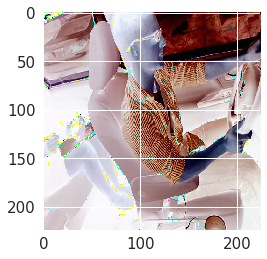

In [5]:
# Visualizing a sample preprocessed image from generator
plt.imshow(train_img[0])
plt.show()

In [6]:
(trn_classes,trn_labels, filenames, test_filenames) = get_classes()

Found 22424 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


### Initializing Model

In [41]:
# Initializing resnet model
import gc
from keras.applications import ResNet50
gc.collect() 
inp = Input(shape=(224,224,3))
resnet = ResNet50(include_top=False,input_tensor=inp,classes=10, pooling='avg')

In [42]:
# res_feats = resnet.predict(train_img, batch_size=64, verbose=1)

In [43]:
# # Initializing softmax
#inp_res = resnet.output_layers #Input(resnet.output_shape[1:])
#x = Flatten()(inp_res)
x = Dropout(.2)(resnet.get_output_at(-1))
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.2)(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(.3)(x)
x = Dense(10, activation='softmax')(x)
sm_model = Model(inp, x)

In [44]:
sm_model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0), loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [25]:
sm_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [45]:
def get_callbacks(res_path):
    es = EarlyStopping(patience=4, verbose=1, monitor='val_loss')
    rlrp = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_loss')
    ckp = ModelCheckpoint(res_path+'model.hdf5', monitor='val_loss', mode = 'min', save_best_only=True, verbose=1)
    return es, rlrp, ckp

### Training

In [46]:
ver = 'benchmark_V5'
res_path = '../results/'+ver+'/'
if not os.path.exists(res_path):
    os.makedirs(res_path)

In [47]:
# For trainig look at the accuracy and run for 3-3 epochs for better convergence
es, rlrp, ckp = get_callbacks(res_path)
plot_losses = PlotLosses()
sm_model.fit(train_img, trn_labels ,batch_size=32, epochs=3, verbose=1)
             #callbacks=[es, rlrp, ckp])

Epoch 1/3
22424/22424 [==============================] - 201s 9ms/step - loss: 0.1836 - acc: 0.9492
Epoch 2/3
22424/22424 [==============================] - 192s 9ms/step - loss: 0.0133 - acc: 0.9981
Epoch 3/3
22424/22424 [==============================] - 191s 9ms/step - loss: 0.0058 - acc: 0.9996


### Predictions

In [48]:
sm_model.save_weights(res_path+'model.hdf5')

In [49]:
sm_model.load_weights(res_path+'model.hdf5')
sm_model.evaluate(train_img, trn_labels, batch_size=128)

22424/22424 [==============================] - 68s 3ms/step


[0.00050284004756264442, 1.0]

In [50]:
# Test generator(put the test folder in test_all folder)
test_imgs = get_batches('../data/test_all/', batch_size=128)
pred_res = sm_model.predict_generator(test_imgs, verbose=1)

Found 79726 images belonging to 1 classes.
623/623 [==============================] - 407s 654ms/step


In [51]:
classes = sorted(train_gen.class_indices, key=train_gen.class_indices.get)

In [52]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)
sub = do_clip(pred_res,0.93)

In [53]:
classes = sorted(train_gen.class_indices, key=train_gen.class_indices.get)
submission = pd.DataFrame(sub, columns=classes)
submission.insert(0, 'img', [a[5:] for a in test_filenames])
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.007778,0.007778,0.007778,0.007778,0.016978,0.930000,0.007778,0.007778,0.007778,0.007778
1,img_10.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.930000,0.007778,0.007778,0.007778,0.007778
2,img_100.jpg,0.700751,0.019083,0.007778,0.007778,0.007778,0.009979,0.007778,0.007778,0.158042,0.090027
3,img_1000.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.930000,0.007778
4,img_100000.jpg,0.007778,0.007778,0.007778,0.930000,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778


In [54]:
submission.to_csv(res_path+'sub'+ver+'.csv', index=False)

In [55]:
res_path+'sub'+ver+'.csv'

'../results/benchmark_V5/subbenchmark_V5.csv'

In [56]:
!kg submit ../results/benchmark_V5/subbenchmark_V5.csv

0.55096


### SVM classifier

In [57]:
from sklearn.svm import SVC

In [58]:
# Input features to resnet
res_feats = resnet.predict(train_img, batch_size=64, verbose=1)

22424/22424 [==============================] - 71s 3ms/step


In [64]:
clf=SVC(probability=True, verbose=True, kernel='linear')

In [66]:
%%time
# Fitting all the values to SVM
clf.fit(res_feats, trn_classes)

[LibSVM]CPU times: user 4min 12s, sys: 143 ms, total: 4min 12s
Wall time: 4min 10s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [62]:
# Test Input features to resnet
pred_test_res = resnet.predict_generator(test_imgs, verbose=1)

623/623 [==============================] - 407s 653ms/step


In [67]:
%%time
# Prediction of SVM
pred = clf.predict_proba(pred_test_res)
pred.shape

CPU times: user 5min 25s, sys: 408 ms, total: 5min 26s
Wall time: 5min 23s


In [68]:
sub = do_clip(pred,0.93)
classes = sorted(train_gen.class_indices, key=train_gen.class_indices.get)
submission = pd.DataFrame(sub, columns=classes)
submission.insert(0, 'img', [a[5:] for a in test_filenames])
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.009284,0.007778,0.007778,0.010677,0.015670,0.930000,0.007778,0.007778,0.009417,0.010501
1,img_10.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.930000,0.007778,0.007778,0.007778,0.007778
2,img_100.jpg,0.444277,0.016553,0.007778,0.007778,0.007778,0.027585,0.007778,0.007778,0.114250,0.380676
3,img_1000.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.930000,0.007778
4,img_100000.jpg,0.008600,0.007778,0.007778,0.930000,0.009021,0.017791,0.007778,0.007778,0.010467,0.011861


In [69]:
submission.to_csv(res_path+'sub'+ver+'svm.csv', index=False)

In [70]:
!kg submit ../results/benchmark_V5/subbenchmark_V5svm.csv

0.61928
